## **BAYESIAN MODELS**


**BASICS:**

Bayes Theorem:

![alt text](fig/bayes.png "Title")

Here, we replace H with hypothesis and D with data, Bayes' theorem tells us how to compute the probability of a hypothesis H given the data D. Where:

![alt text](fig/bayes_details.png "Title")

This means:

* **The prior distribution** should reflect what we know about the value of some parameter before seeing the data D.

* **The likelihood** is how we will introduce data in our analysis. It is an expression of the plausibility of the data given the parameters.

* **The posterior distribution** is the result of the Bayesian analysis and reflects all that we know about a problem (given our data and model). The posterior is a probability distribution for the parameters in our model and not a single value. **This distribution is a balance of the prior and the likelihood**. There is a joke that says: A Bayesian is one who, vaguely expecting a horse, and catching a glimpse of a donkey, strongly believes he has seen a mule. One way to kill the mood after hearing this joke is to explain that **if the likelihood and priors are both vague you will get a posterior reflecting vague beliefs about seeing a mule rather than strong ones**. 

We can think of the posterior as the updated prior in the light of the data. In fact, the posterior of one analysis can be used as the prior of a new analysis after collecting new data. This makes Bayesian analysis particularly suitable for analyzing data that becomes available in sequential order. 

The last term is the **evidence**, also known as marginal likelihood. Formally, the evidence is the probability of observing the data averaged over all the possible values the parameters can take. Most of the time we will not care about the evidence, and we will think of it as a simple normalization factor. This will not be problematic since we will only care about the relative values of the parameters and not their absolute ones:

![alt text](fig/bayes_alt.png "Title")

**Concepts to have in consideration:**

* **Conjugate prior** of a likelihood is a prior that, when used in combination with the given likelihood, returns a posterior with the same functional form as the prior. For example: every time we use a beta distribution as prior and a binomial distribution as likelihood, we will get a beta as a posterior. The Gaussian distribution is the conjugate prior of itself. 

**Results of a Bayesian Model:**

* The result of a Bayesian analysis is the posterior distribution, not a single value but a distribution of plausible values given the data and our model.
* The most probable value is given by the mode of the posterior (the peak of the distribution).
* The spread of the posterior is proportional to the uncertainty about the value of a parameter; the more spread the distribution, the less certain we are.
* Given a sufficiently large amount of data, two or more Bayesian models with different priors will tend to converge to the same result. In the limit of infinite data, no matter which prior we use, we will always get the same posterior. Remember that infinite is a limit and not a number, so from a practical point of view in some cases the infinite amount of data could be approximated with a really small number of data points.

**Sequential Bayesian Models**

* How fast posteriors converge to the same distribution depends on the data and the model.

* Something not obvious is that we will get the same result if we **update the posterior sequentially** than if we do it all at once. We can compute the posterior 150 times, each time adding one more observation and using the obtained posterior as the new prior, or we can just compute one posterior for the 150 tosses at once. The result will be exactly the same. This feature not only makes perfect sense, also leads to a natural way of updating our estimations when we get new data, a situation common in many data analysis problems.

## **Posterior Predictive Checks**

The main goal is to check for auto-consistency. The generated data and the observed data should look more or less similar, otherwise there was some problem during the modeling or some problem feeding the data to the model. **But even if we did not make any mistake, differences could arise.** Trying to understand the mismatch could lead us to improve models or at least to understand their limitations. 

Knowing which part of our problem/data the model is capturing well and which it is not is valuable information even if we do not know how to improve
the model. Maybe the model captures well the mean behavior of our data but fails to predict rare values. This could be problematic for us, or maybe we only care about the mean, so this model will be okay for us. The general aim will be not to declare that a model is false; instead **we follow George Box's advice, all models are wrong, but some are useful.** We just want to know which part of the model we can trust and try to test whether the model is a good fit for our specific purpose. 



## **Example:**

**Coin-flipping, the computational approach**

We toss a coin a number of times and record how many heads and tails we get. Based on this data we try to answer questions such as is the coin fair? Or, more generally, how biased is the coin?

The coin-flipping problem is a great example to learn the basic of Bayesian statistics; on the one hand, it is about tossing coins, something familiar to almost anyone; on the other, it is a simple model that we can solve and compute with ease. Besides, many real problems consist of binary mutually exclusive outcomes such as 0 or 1, positive or negative, odds or evens, spam or ham, safe or unsafe, healthy or unhealthy, and so on. Thus, **even when we are talking about coins, this model applies to any of those problems.**

1. The first requirement is to get our data. 

In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

In [2]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments) 
print(data)

[1 0 0 0]


2. Model specification

Now that we have the data, we need to specify the model. This is done by specifying the likelihood and the prior using probability distributions. As the likelihood, we will use the binomial distribution with n=1 and p = θ , and for the prior a beta with α = β = 1 . This beta distribution is equivalent to a uniform distribution in the interval [0,1]. We can write the model using mathematical notation as follows:

θ ∼ Beta(α , β)

y ∼ Bin( n = 1, p = θ )

This statistical model has an almost one-to-one translation to the PyMC3 syntax.

In [3]:
with pm.Model() as our_first_model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

logp = -2.7726, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 890.64it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 11448.70draws/s]
The number of effective samples is smaller than 25% for some parameters.


**Statistical parameters:**

* The **first line** of the code creates a container for our first model, **PyMC3 uses the with statement** to indicate that everything inside the **with block** points to the same model. Our model is called our_first_model. 
* The **second line** specifies the prior, and, the syntax follows the mathematical notation closely. We call the random variable theta. Please note that this name matches the first argument of the PyMC3 Beta function; having both names the same is a good practice to avoid confusion. Then we will use the name of the variable to extract information from the sampled posterior. The variable theta is a stochastic variable; we can think of this variable as the rule to generate numbers from a given distribution (a beta distribution in this case) and not actual numbers. 
* The **third line specifies** the likelihood following the same syntax as for the prior except that we pass the data using the observed argument. This is the way in which we tell PyMC3 that this is the likelihood. The data can be a Python list, a NumPy array or a Pandas DataFrame. 

That's all it takes to specify our model!


**Calculation steps**

* In the **forth line** we call **find_MAP**; this function calls optimization routines provided by SciPy and tries to return the Maximum a Posteriori (MAP). Calling find_MAP is optional; sometimes **it works to provide a good starting point for the sampling method**, sometimes it
does not help too much, so often we can avoid it. 
* Then, the next line is used to define the sampling method. Here we are using Metropolis-Hastings, simply called Metropolis. PyMC3 allows us to assign different samplers to different random variables; for now we have a model with only one parameter, but later we will have more variables. Alternatively, **we can even omit this line and PyMC3 will assign samplers automatically to each variable** based on properties of those variables. For example, NUTS works only for continuous variables and hence cannot be used with a discrete one, Metropolis can deal with discrete variables, and other types of variables have specially dedicated samplers. In general we should let PyMC3 choose the sampler for us. 
* The last line performs the inference. The first argument is the number of samples we want, and the second and third arguments are the sampling method and the starting point. 

## **Diagnosing the sampling process**

* **Convergence**

Generally, the first task we will perform is to check what the results look like. The traceplot function is ideally suited to this task:

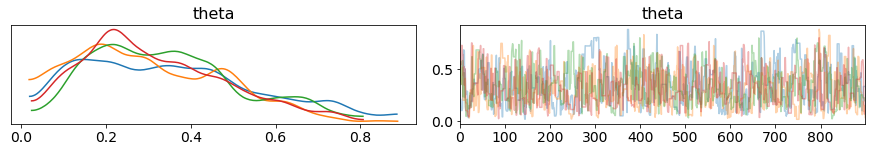

In [4]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real});

We get two plots for each unobserved variable:

* On the left, we get a **kernel density estimation (KDE) plot**; this is like the smoothed version of a histogram. Often, as the number of data increases, the distribution of each parameter will tend to become Gaussian-like; this is due to the law of the large numbers. Of course, this is not always true. 

* On the right, we get the **individual sampled values** at each step during the sampling. It should look like white noise; we are looking for good mixing. We should not see any recognizable pattern.

The model was run a model several times in parallel and thus get a parallel chain for the same parameter. Using **traceplot**, we plot all the chains for the same parameter in the same plot. Since each chain is independent of the others and each chain should be a good sample, all the chain should look similar to each other. Besides checking for convergence, these parallel chains can be used also for inference.


Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 11422.33draws/s]
The number of effective samples is smaller than 25% for some parameters.


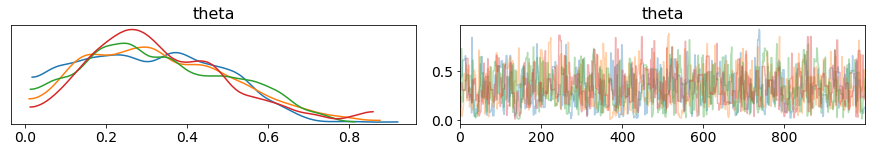

In [5]:
with our_first_model:
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step)
    
burnin = 0
multi_chain = multi_trace[burnin:] 
pm.traceplot(multi_chain, lines={'theta':theta_real});

A quantitative way to check for convergence is by using the Gelman-Rubin test. The idea of this test is to compare the variance between chains with the variance within chains, so of course we need more than one chain for this test to work. Ideally, we should expect a value equal to Rˆ = 1. As an empirical rule, we will be ok with a value
below 1.1; higher values are signaling a lack of convergence.

In [6]:
pm.gelman_rubin(multi_chain)

/Users/erikapat/anaconda3/lib/python3.7/site-packages/pymc3/stats/__init__.py:43: UserWarning: gelman_rubin has been deprecated. In the future, use rhat instead.
  warnings.warn("gelman_rubin has been deprecated. In the future, use rhat instead.")


<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 1.003

We can also visualize the Rˆ for every parameter together with the mean, 50% HPD and 95% HPD for each parameter distribution using the function forestplot:

/Users/erikapat/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


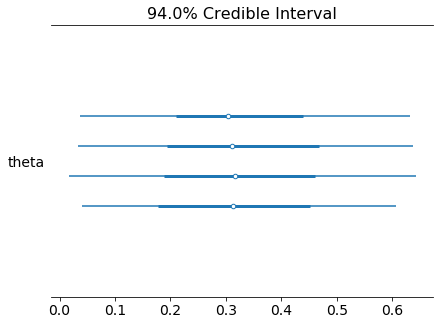

In [7]:
pm.forestplot(multi_chain, varnames=['theta']);

The function summary provides a text-format summary of the posterior. We get the mean, standard deviation, and the HPD intervals:

In [8]:
pm.summary(multi_chain)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.329,0.175,0.037,0.638,0.006,0.004,931.0,931.0,871.0,904.0,1.0


Alternatively, the function df_summary, returns a similar result but using a Pandas DataFrame:

One of the quantities returned is the mc_error. This is an estimation of the error introduced by the sampling method. The estimation takes into account that the samples are not truly independent of each other. The mc_error is the standard error of the means x of n blocks, each block is just a portion of the trace:

![alt text](fig/bayes_alt.png "Title")

This error should be of course below the precision we want in our results. Since the sampling methods are stochastic, every time we re-run our models the values returned by summary or df_summary will be different; nevertheless, they should be similar for different runs. If they are not as similar as we want we may need more samples.

## **Autocorrelation**

An ideal sample will lack autocorrelation, that is, a value at one point should be independent of the values at other points. In practice, samples generated from MCMC methods, especially Metropolis-Hastings, can be autocorrelated. Some models will also lead to more autocorrelated samples due to correlations in the way one parameter depends on the others. PyMC3 comes with a convenient function to plot the autocorrelation:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c29698390>,
      dtype=object)

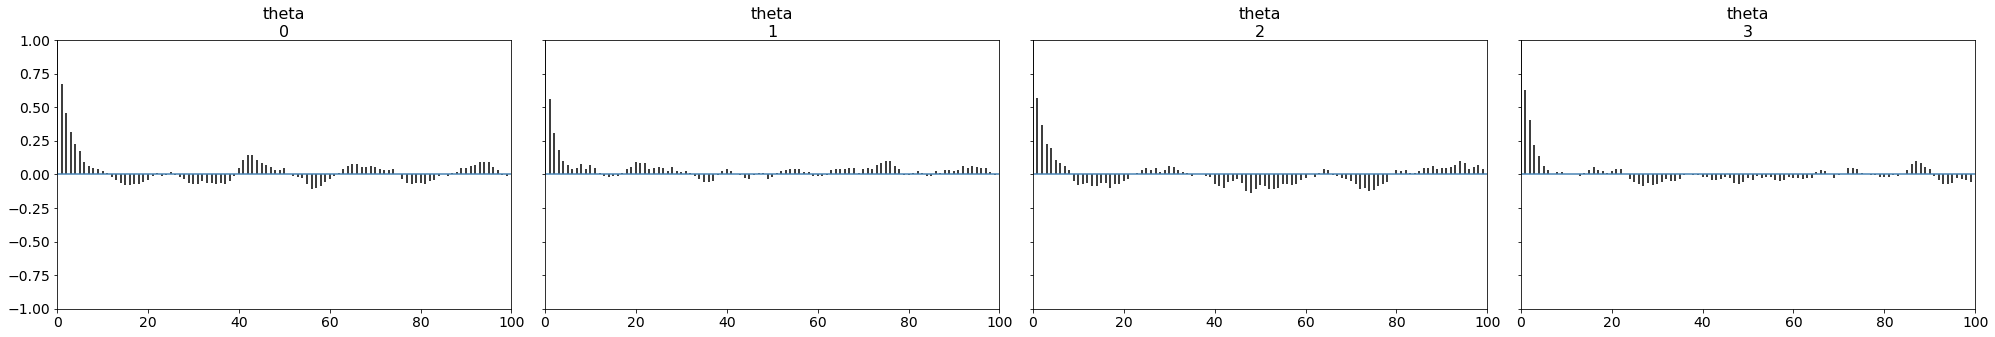

In [24]:
pm.autocorrplot(multi_chain)

The plot shows the average correlation of sample values compared to successive points (up to 100 points). Ideally we should see no autocorrelation, in practice; we seek samples that quickly drop to low values of autocorrelation. The more autocorrelated a parameter is, the larger the number of samples we will need
to obtain a given precision; that is, autocorrelation has the detrimental effect of lowering the effective number of samples.


## **Effective size**

A sample with autocorrelation has less information than a sample of the same size without autocorrelation. Hence, given a sample of a certain size with a certain degree of autocorrelation we could try to estimate what will be the size of the sample with the same information without autocorrelation. That number will be the effective size of the sample. Ideally both quantities should be the same; the closer the two numbers the more efficient our sampling. The effective size of sample could serve us as a guide. If we want to estimate mean values of a distribution we will need an effective sample of at least 100 samples; if we want to estimate quantities that depend on the tails of distribution, such as the limits of credible intervals, we will need an effective size of 1000 to 10000 samples.

In [11]:
pm.effective_n(multi_chain)['theta']

/Users/erikapat/anaconda3/lib/python3.7/site-packages/pymc3/stats/__init__.py:50: UserWarning: effective_n has been deprecated. In the future, use ess instead.
  warnings.warn("effective_n has been deprecated. In the future, use ess instead.")


<xarray.DataArray 'theta' ()>
array(870.67100285)

One way to have more efficient sampling is of course to use a better sampling method. An alternative is to transform the data or re-parametrize the model. Another commonly used option in the literature is to thin a chain. Thinning is just taking every k-esim observation. In Python, we would say taking slices of a chain. Thinning will indeed reduce the autocorrelation, but at the expense of reducing the number
of samples. So in practice, it is generally a better idea to just increase the number of samples instead of doing thinning. Nonetheless, thinning can be useful, for example, to reduce storage requirements. When high autocorrelation cannot be avoided, we are obligated to compute long chains, and if our models contain many parameters storage can become problematic. Also we may need to do some post-processing of the posterior such as performing some expensive computation. In such cases having a smaller sample of minimally autocorrelated values could be important.

All the diagnostic tests we have seen have an empirical component and none of them is definitive. In practice, we run several tests and, if all of them look OK, then we proceed to further analyses. If we detect problems we have to go back and fix them; this is just part of the iterative process of modeling. It is also important to notice that having to run convergence tests is not really part of the Bayesian theory but is about the Bayesian practice, given that we are computing the posterior using numerical methods.

**Summarizing the posterior**

As we have already seen, the result of a Bayesian analysis is a posterior distribution. This contains all the information about our parameters, according to the data and the model. One way to visually summarize the posterior is to use the plot_posterior function that comes with PyMC3. This function accepts a PyMC3 trace or a NumPy array as a main argument. By default, plot_posterior shows a histogram for the credible parameters together with the mean of the distribution and the 95% HPD as a thick black line at the bottom of the plot. Different interval values can be set for the HPD with the argument alpha_level. We are going to refer to this type of plot as Kruschke's plot, since John K. Kruschke introduced this type of plot in his great book Doing Bayesian Data Analysis:

AttributeError: 'Line2D' object has no property 'kde_plot'

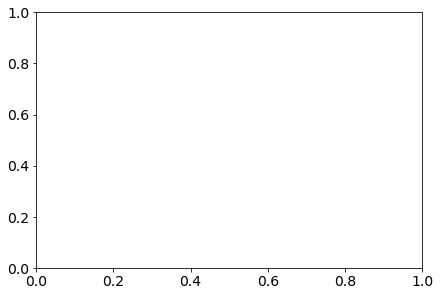

In [25]:
import matplotlib.pyplot as plt
plt.show()
pm.plot_posterior(multi_chain, kde_plot=True)

AttributeError: 'Line2D' object has no property 'kde_plot'

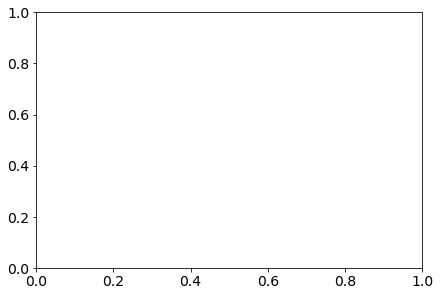

In [26]:
pm.plot_posterior(multi_chain, kde_plot=True, rope=[0.45, .55])